# PROJECT: PARTICLE DETECTOR DATA ANALYSIS
### Dataset: Run260, Calibration Run

<a id =6></a><br>
The project is outlined as following:
 
 - [INTRODUCTION: THE DATA](#1)
 
 - [ADDING NEW COLUMNS](#2)
 
 - [GATHERING EVENTS](#3)
 
 - [FINDING TRAJECTORIES](#4)
 
 - [VISUALIZING THE EVENTS](#5)
 
 - [DETECTOR MATRIX](#7)
 
 

In [61]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from os import listdir
from os.path import isfile, join, getsize
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string)) # for markdown purposes
from numba import vectorize, int64, int32, jit, njit, cuda, float64

***

# <a id =1></a><br> I. INTRODUCTION: THE DATA
[Content Outline](#6)

In this project, we analyze the data obtained through a set of particle detectors. As shown in the figure below, the detectors consist on four layers of cells fulls of a gas. Each of the cells is traversed by an anodic cable in its middle. When a particle traverses the gas, it ionizes it, with the ions being then attracted towards the cable. The cell then emmits a signal when the ions reach the cable. \
The ions can be considered to travel at a constat drift velocity $v_d$ towards the cable. The impact possition in a cell $x$ can be expressed as
    
    
$$
x = v_d (t_R - t_0),
$$
    
being $t_0$ as the pedestal time and $t_R$ the time recorded by the detector. As the maximum drift time  $T_{Max} = \frac{L}{2 v_d} = 390$ ns ($L=42$ mm is the lenght of the cell) is a known country, $t_0$ can be calculated, which will be explained later.    
\
The data obtained are encoded in a CSV file. The way we can interpret its content is exlained as it is needed. It is the goal of this project to analyze these data so that we can track the trajectories of the particles through them. More specifically, the tasks to do are:
    
    - grouping the data into events corresponding to a particle hitting the detector,
    - obtain and plot the drift times, and
    - plot the trajectory of the particle with left - right ambiguity.
    
This was done for both a calibration run and for the data obtained in a real experiment.

![(Picture of detector configuration)](./detector.jpg)

In [62]:
# Set as FALSE for Calibration run 
REAL_DATA = False

# Limit the amount of data we are accepting 
if REAL_DATA == True:
    mypath = '../data/Run000333/'
else:
    mypath = '../data/Run000260/'

max_mb = 256 # maximum size of data in mb to read
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
mb = 0
for i in range(len(files)):
    mb += getsize(files[i])/1024**2 # getsize returns size in bytes
    if mb >= max_mb:
        files = files[:(i-1)]
        break

# Concatenate the files and load the data
data = pd.concat([pd.read_csv(file) for file in files], axis = 0)
data.reset_index(inplace=True, drop=True) #This resets the index from 0 to onwards
# data = pd.read_csv(files[0])

# Drop the 'HEAD' column
data.drop('HEAD', inplace=True, axis=1) # We remove the 'HEAD', inplace = True because we return nothing

# Print the description of the data
printmd('## DESCRIPTION OF THE DATA')
print('Files concatenated:', '\n', files, '\n') # To check which files are read
print(data.info())
# display(data.describe())

## DESCRIPTION OF THE DATA

Files concatenated: 
 ['../data/Run000260/data_000000.txt', '../data/Run000260/data_000001.txt', '../data/Run000260/data_000002.txt', '../data/Run000260/data_000003.txt', '../data/Run000260/data_000004.txt', '../data/Run000260/data_000005.txt', '../data/Run000260/data_000006.txt', '../data/Run000260/data_000007.txt'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879056 entries, 0 to 9879055
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   FPGA         int64  
 1   TDC_CHANNEL  int64  
 2   ORBIT_CNT    int64  
 3   BX_COUNTER   float64
 4   TDC_MEAS     float64
dtypes: float64(2), int64(3)
memory usage: 376.9 MB
None


In [63]:
#Visualize the first 10 entries of the file
printmd('## THE DATAFRAME')
printmd('The dataframe below presents the first 10 hits as presented in the raw data.')
display(data.head(10))

## THE DATAFRAME

The dataframe below presents the first 10 hits as presented in the raw data.

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,116,1897414884,1533.0,24.0
1,1,71,1897414887,1650.0,21.0
2,1,67,1897414914,980.0,8.0
3,1,70,1897414922,1287.0,8.0
4,0,57,1897414922,2162.0,22.0
5,0,24,1897414934,2014.0,13.0
6,0,26,1897414934,2014.0,20.0
7,0,26,1897414934,2026.0,13.0
8,0,139,1897414934,2028.0,0.0
9,0,33,1897414934,2026.0,14.0


## HISTOGRAM OF HITS PER TDC CHANNEL

Remark: There are a lot of hits falling under the mean time trigger channel: 139.

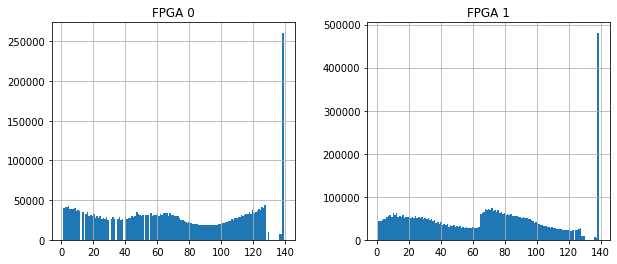

In [64]:
# Plot histogram
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

df_0 = data[data['FPGA']==0]
df_1 = data[data['FPGA']==1]

max_channel = data['TDC_CHANNEL'].max()
df_0.hist('TDC_CHANNEL', ax=ax1, bins=max_channel)#, range=(137,138))
df_1.hist('TDC_CHANNEL', ax=ax2, bins=max_channel)#, range=(137,138))
ax1.set_title('FPGA 0')
ax2.set_title('FPGA 1')

printmd('## HISTOGRAM OF HITS PER TDC CHANNEL')
printmd('Remark: There are a lot of hits falling under the mean time trigger channel: 139.')
plt.show()

# The difference between the channel distributions reflect the difference between the beams used in 
# the calibration run and the physics run. 
# Discontinuity and lesser amplitudes: shift in chamber

***
# <a id =2></a><br> II. ADDING NEW COLUMNS: TIME, DETECTOR, LAYER, AND CELL
 [Content Outline](#6)

## CONSTANTS: TRIGGER CHANNELS AND TMAX, L, Vd

In [65]:
st1 = 137  # Scintillator trigger channel 1
st2 = 138  # Scintillator trigger channel 2
mtt = 139  # Mean-time trigger channel
T_M = 390  #(maximum drift time in ns)
L = 42  # (lenght of the cell in mm)
v_d = L/(2*T_M)  # (constant drift velocity in mm/ns)

#!!! deleted the detector -1 setting (useless)

 ## TIME COLUMN
 
 Let's add a column to the existing data.

This new column will be the time measurements(ns). The time measurement in nanoseconds is given by:

```python
 data['time']=data['ORBIT_CNT']*2564*25+data['BX_COUNTER']*25+data['TDC_MEAS']*25/30
```
 
Now, the rate of passage of particles through the detector was rather limited, i.e. the chance to get two particle within the same orbit is extremely small. Therefore we can drop the orbit part of the formula yields

In [66]:
data['time'] = data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30

# We have added a new time column to the data. The first 5 rows are
data.head(5)

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
0,1,116,1897414884,1533.0,24.0,38345.000000
1,1,71,1897414887,1650.0,21.0,41267.500000
2,1,67,1897414914,980.0,8.0,24506.666667
3,1,70,1897414922,1287.0,8.0,32181.666667
4,0,57,1897414922,2162.0,22.0,54068.333333


As stated earlier, the actual time taken by the ionization to reach the anodic wire (drift time) is proportional to the distance:

$$
x = v_d t_i= v_d(t_R-t_0)
$$

where $v_d$ is the constant drift velocity, $t_R$ is the time recorded by the electronics and $t_0$ is a time pedestal which needs to be determined for every particles crossing the detector (the drift time is $t_R-t_0$). This is possible thanks to the geometry of the layers, more precisely by the fact that they are staggered by exactly half a cell. 

## DETECTOR, LAYER, AND CELL COLUMNS

Before processing the dataset, we have to create some missing columns, in fact the DataFrame with the events must contain the following information:
* CHAMBER, which is the Detector number. The data to be analyzed have been gathered by a series of (4) particle detectors: [1-4]
* LAYER.  Such detectors were composed by four layers of cells: [1-4];
* CELL, which is in the number of the cell.  The actual detector has 16 cells per layer: [1-16]
* POSTION, which is the position where a particle traverses the cell [0-21] (in mm. The maximum 21 mm value corresponds to the position of the anodic wire to where the particles travel. In this case the left-right ambiguity is NOT resolved). 

The channels are mapped to the four detectors in the following ways:

* Detector 1 $\rightarrow$ FPGA 0, TDC_CHANNEL in [1-64]
* Detector 2 $\rightarrow$ FPGA 0, TDC_CHANNEL in [65-128]
* Detector 3 $\rightarrow$ FPGA 1, TDC_CHANNEL in [1-64]
* Detector 4 $\rightarrow$ FPGA 1, TDC_CHANNEL in [65-128]

Notice that since we have 4 layers with 16 cells per layes, each detector will have 64 cells. Therefore, we can assume that the TDC_CHANNEL is a label for all the cells in the chamber.

Even though not used as such, an external trigger was present anyway. When it fired a special 64 bit word (a row in the csv file) were produced enconding the trigger information, i.e. the timing at which it occurred and which of the kind of trigger fired. More precisely:

* Mean-time trigger: TDC_CHANNEL=139
* Scintillator trigger: TDC_CHANNEL=137 or 138

In [67]:
# Define function to add the detector, layer and cell columns 

@vectorize([int64(int64, int64)])
def giveDetector(fpga, channel):
    if channel > 128:
        return -1

    channel -= 1
    return fpga*2 + 1 + channel // 64

@vectorize([int64(int64)])
def giveLayer(channel):
    if channel > 128:
        return -1

    layer_map = {0 : 1,
                 1 : 4,
                 2 : 2,
                 3 : 3}

    cell_index = channel % 64
    layer = layer_map[cell_index % 4]
    
    return layer

@vectorize([int64(int64)])
def giveCell(channel):
    if channel > 128:
        return -1

    channel -= 1
    cell_index = channel % 64
    cell = cell_index // 4 + 1

    return cell

# Test of functions(one particular layer and detector arrangement)
if __name__ == '__main__':
    first_cell_of_layer = 67
    a = np.arange(first_cell_of_layer,first_cell_of_layer+16*4,4)
    print('(Detectory, Layer, Cell) example: \n',list(zip(giveDetector(0,a), giveLayer(a), giveCell(a))))
    

(Detectory, Layer, Cell) example: 
 [(2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 3, 10), (2, 3, 11), (2, 3, 12), (2, 3, 13), (2, 3, 14), (2, 3, 15), (2, 3, 16)]


In [68]:
# Calculate the detector, layer & cell columns according to the previous functions
data['detector'] = giveDetector(data['FPGA'], data['TDC_CHANNEL'])
data['layer'] = giveLayer(data['TDC_CHANNEL'])
data['cell'] = giveCell(data['TDC_CHANNEL'])

printmd("Dataframe now has new columns: time, detector, layer, and cell.")
display(data.head(5))

Dataframe now has new columns: time, detector, layer, and cell.

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time,detector,layer,cell
0,1,116,1897414884,1533.0,24.0,38345.000000,4,1,13
1,1,71,1897414887,1650.0,21.0,41267.500000,4,3,2
2,1,67,1897414914,980.0,8.0,24506.666667,4,3,1
3,1,70,1897414922,1287.0,8.0,32181.666667,4,2,2
4,0,57,1897414922,2162.0,22.0,54068.333333,1,4,15


***
# <a id =3></a><br>III. FINDING EVENTS 
 [Content Outline](#6)

A trigger dataset is formed by applying a mask to the original data in order to isolate the hits that correspond to the TDC_CHANNEL 139. Similar lines of code are presented for the two other trigger channels, scintillator 1 and 2. 

In [69]:
trigger_mtt = data.loc[data['TDC_CHANNEL']==mtt, ['ORBIT_CNT','time']]
trigger_st = data.loc[(data['TDC_CHANNEL']==st1) | (data['TDC_CHANNEL']==st2), ['ORBIT_CNT','time']]

display(trigger_mtt.head())
if not trigger_st.empty:
    display(trigger_st.head())

,ORBIT_CNT,time
8,1897414934,50700.0
72,1897415301,70300.0
87,1897415425,33375.0
115,1897415544,30850.0
140,1897415674,29950.0


,ORBIT_CNT,time
24235,1897537507,26853.333333
24238,1897537507,26857.500000
24239,1897537507,26850.833333
24241,1897537507,26860.000000
244487,1918505505,1525.833333


Using the `.isin()`  !!! function, the orbits found in trigger_mtt data is isolated from the original dataset to produce the 'events' dataset because, supposedly, **one event corresponds to one common orbit.** The next lines of code sorts the hits by orbits and reindexed to present the data for each event.

In [70]:
#.isin function compares the two arrays and takes only the orbits that are found in the trigger
events_mtt = data.loc[data['ORBIT_CNT'].isin(trigger_mtt['ORBIT_CNT'])]
events_st = data.loc[data['ORBIT_CNT'].isin(trigger_st['ORBIT_CNT'])]

def create_events(df):
    events = df.copy(deep=False)
    # We remove the events that are in channels above 128
    events = events[events['TDC_CHANNEL'] <= 128]

    # We now group by orbit
    events['event'] = events.groupby('ORBIT_CNT').ngroup()+1

    # Common orbits correspond to a single event
    events.set_index(['event', events.index], inplace=True) # We make the events column an index
    events.rename_axis(('event','index'), inplace=True)
    events.sort_values(['ORBIT_CNT','detector','layer','cell'], inplace=True) # We sort according to these categories
    
    return events

printmd('## Events in the Mean time Trigger')
events_mtt = create_events(events_mtt)
display(events_mtt.head(5))
if not trigger_st.empty:
    printmd('## Events in the Scintillator Trigger')
    events_st = create_events(events_st)
    display(events_st.head(5))

## Events in the Mean time Trigger

FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                        
1     5         0           24  1897414934      2014.0      13.0   
      6         0           26  1897414934      2014.0      20.0   
      7         0           26  1897414934      2026.0      13.0   
      10        0           27  1897414934      2024.0      11.0   
      11        0           29  1897414934      2026.0       9.0   

                     time  detector  layer  cell  
event index                                       
1     5      50360.833333         1      1     6  
      6      50366.666667         1      2     7  
      7      50660.833333         1      2     7  
      10     50609.166667         1      3     7  
      11     50657.500000         1      4     8

## Events in the Scintillator Trigger

FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                         
1     24242      1           80  1897537507      1857.0      11.0   
2     244481     0           16  1918505505        26.0      17.0   
      244485     0           11  1918505505        34.0      12.0   
      244483     0            9  1918505505        27.0      12.0   
      244482     1           68  1918505505        34.0      25.0   

                      time  detector  layer  cell  
event index                                        
1     24242   46434.166667         4      1     4  
2     244481    664.166667         1      1     4  
      244485    860.000000         1      3     3  
      244483    685.000000         1      4     3  
      244482    870.833333         4      1     1

***
# <a id =4></a><br> IV. FINDING THE TRAJECTORIES
 [Content Outline](#6)

In [71]:
#!!! whole cell is a bit different

def findTrajectories(df):
    data = df.copy(deep=False)
    data['t0_123'] = 0
    data['t0_234'] = 0
    for i in data.index.get_level_values(0).unique():
        present_detectors = data.loc[i,'detector'].unique()
        ev = data.loc[i].copy(deep=False)
        
        for det in present_detectors:
            sub_ev = ev.loc[ev['detector'] == det].copy(deep=False)
            for l in range(1,4):
                fst_layer = sub_ev.loc[sub_ev['layer'] == l, 'cell']
                sec_layer = sub_ev.loc[sub_ev['layer'] == l+1, 'cell']

                # Find successor for each cell in layer
                if l % 2 == 0:
                    successor_mask = fst_layer.isin(sec_layer) | fst_layer.isin(sec_layer+1)
                else:
                    successor_mask = fst_layer.isin(sec_layer) | fst_layer.isin(sec_layer-1)
                
                # Drop whole sub_event if the current layer is completely empty
                if successor_mask.sum() == 0:
                    sub_ev['t0_1'] = np.nan
                    sub_ev['t0_2'] = np.nan
                    break

                else:
                    # Drop rows where no successor was found
                    sub_ev.loc[(successor_mask==False).index, 't0_1'] = np.nan
                    sub_ev.loc[(successor_mask==False).index, 't0_2'] = np.nan

            na_mask = sub_ev['t0_1'].notna()
            if na_mask.sum() > 0:
                t_1 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==1).index, 't0_1'].iloc[0]
                t_2 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==2).index, 't0_1'].iloc[0]
                t_3 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==3).index, 't0_1'].iloc[0]
                t_4 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==4).index, 't0_1'].iloc[0]
                sub_ev.loc[na_mask,'t0_1'] = 0.5*(0.5*(t_1 + t_3) + t_2)
                sub_ev.loc[na_mask, 't0_2'] = 0.5*(0.5*(t_2 + t_4) + t_3)

    return data


# np.isin or in function of numpy/python is not supported by numba
# That's why we make a new .isin function to be able to use the @njit decorator
@njit
def myIsin(array_a, array_b):
    result = np.zeros(len(array_a), dtype=np.bool_)
    for i,a in enumerate(array_a):
        for j,b in enumerate(array_b):
            if a == b:
                result[i] = True
                break
    return result


@njit
def findTrajectories_np(data, inds, columns):
    det_ind, lay_ind, cel_ind, time_ind, t0_1_ind, t0_2_ind = columns #detector, layer, cel, time, 1t0, 2t0 are the columns !!! (deleted ???)
    #np.roll (array, shift, axis)  #elements of the input array are being shifted
    ev_locs = np.where(inds - np.roll(inds,1)!=0)[0]  #np.where(condition,[x,y]) return elements chosen from x or y depending on condition.
    ev_locs = np.append(ev_locs, [len(inds)])

    for i in range(len(ev_locs)-1):
    
        ev = data[ev_locs[i]:ev_locs[i+1]]

        # Every row registered in same detector?
        if np.unique(ev[:,det_ind]).size != 1: #!!! (deleted ???)
            sub_ev_locs = np.where(ev[:,det_ind]-np.roll(ev[:,det_ind],1)!=0)[0]
            sub_ev_locs = np.append(sub_ev_locs, [len(ev[:,det_ind])])

        else:
            sub_ev_locs = np.array([0,len(ev[:,det_ind])])

        for j in range(len(sub_ev_locs)-1):
            sub_ev = ev[sub_ev_locs[j]:sub_ev_locs[j+1]]

            for l in range(1,4):
                fst_layer = sub_ev[sub_ev[:,lay_ind]==l,cel_ind]
                sec_layer = sub_ev[sub_ev[:,lay_ind]==l+1,cel_ind]

                # Find successor for each cell in layer
                if l % 2 == 0:
                    successor_mask = myIsin(fst_layer, sec_layer) | myIsin(fst_layer, sec_layer+1)
                else:
                    successor_mask = myIsin(fst_layer, sec_layer) | myIsin(fst_layer, sec_layer-1)

                # Drop whole sub_event if the current layer is completely empty
                if np.any(successor_mask) == False:
                    sub_ev[:,t0_1_ind] = np.nan
                    sub_ev[:,t0_2_ind] = np.nan
                    break

                # Else mark rows where no predecessor was found
                # if one cell was found with no predecessor
                elif np.all(successor_mask) == False: # False has to be np.array([False]) so that numba broadcasts
                    idx = np.nonzero(successor_mask==np.array([False]))[0] + np.nonzero(sub_ev[:,lay_ind]==l)[0][0]
                    sub_ev[idx,t0_1_ind] = np.nan
                    sub_ev[idx,t0_2_ind] = np.nan

            # Compute t0 if a trajectory was found
            mask = ~np.isnan(sub_ev[:,t0_1_ind]) # mask where values are numbers and not NaN
            if np.any(mask) == True:
                t_1 = sub_ev[sub_ev[mask,lay_ind]==1,time_ind][0]
                t_2 = sub_ev[sub_ev[mask,lay_ind]==2,time_ind][0]
                t_3 = sub_ev[sub_ev[mask,lay_ind]==3,time_ind][0]
                t_4 = sub_ev[sub_ev[mask,lay_ind]==4,time_ind][0]
                sub_ev[mask,t0_1_ind] = 0.5*(0.5*(t_1 + t_3) + t_2 - T_M)
                sub_ev[mask,t0_2_ind] = 0.5*(0.5*(t_2 + t_4) + t_3 - T_M)

    return data


## Computing $t_0$

To compute the constant $t_0$, which is different for every event, we can use the following relation:

$$T_{MAX}=\frac{t_{1}+t_{3}}{2}+t_{2}$$

where $t_1 = t_{1'}-t_0$, $t_2 = t_{2'}-t_0$ and $t_3 = t_{3'}-t_0$, are the drift times of those three cells and $t_{i'}$ is the time measurement of the respective cell. The drift times can be calculated in this way because $t_0$ is essentially the same for each cell in one event, because the particle velocity of the muons is much higher than the drift velocity of the electrons. Then the relation becomes:

$$T_{MAX}=\frac{t_{1'}-t_0+t_{3'}-t_0}{2}+t_{2'}-t_0$$

from which we get:

$$t_0=\frac{t_{1'}+t_{3'}+2t_{2'}-2T_{MAX}}{4}$$

Finally we notice that $t_{1'}$, $t_{2'}$, $t_{3'}$ are the times recorded by each cell, which are already available in our dataset.

In [72]:
def calculate_t0(df, numba_optimized=True):
    events = df.copy(deep=False)

    if not numba_optimized:
        events = findTrajectories(events)

    else:
        events['t0_123'] = 0
        events['t0_234'] = 0
        level0_inds = events.index.get_level_values(0).to_numpy()
        c_names = ['detector', 'layer', 'cell', 'time', 't0_123', 't0_234']
        columns = np.array([events.columns.get_loc(column) for column in c_names])

        data = findTrajectories_np(events.to_numpy(), level0_inds, columns)
        events = pd.DataFrame(data=data, index=events.index, columns=events.columns)

        events['detector'] = events['detector'].astype(np.int32)
        events['layer'] = events['layer'].astype(np.int32)
        events['cell'] = events['cell'].astype(np.int32)

    return events

events_mtt = calculate_t0(events_mtt)
display(events_mtt.head(5))
if not trigger_st.empty:
    events_st = calculate_t0(events_st)
    display(events_st.head(5))

FPGA  TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                          
1     5       0.0         24.0  1.897415e+09      2014.0      13.0   
      6       0.0         26.0  1.897415e+09      2014.0      20.0   
      7       0.0         26.0  1.897415e+09      2026.0      13.0   
      10      0.0         27.0  1.897415e+09      2024.0      11.0   
      11      0.0         29.0  1.897415e+09      2026.0       9.0   

                     time  detector  layer  cell        t0_123     t0_234  
event index                                                                
1     5      50360.833333         1      1     6  50230.833333  50365.625  
      6      50366.666667         1      2     7  50230.833333  50365.625  
      7      50660.833333         1      2     7  50230.833333  50365.625  
      10     50609.166667         1      3     7  50230.833333  50365.625  
      11     50657.500000         1      4     8  50230.833333  50365.625

FPGA  TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                           
1     24242    1.0         80.0  1.897538e+09      1857.0      11.0   
2     244481   0.0         16.0  1.918506e+09        26.0      17.0   
      244485   0.0         11.0  1.918506e+09        34.0      12.0   
      244483   0.0          9.0  1.918506e+09        27.0      12.0   
      244482   1.0         68.0  1.918506e+09        34.0      25.0   

                      time  detector  layer  cell  t0_123  t0_234  
event index                                                        
1     24242   46434.166667         4      1     4     NaN     NaN  
2     244481    664.166667         1      1     4     NaN     NaN  
      244485    860.000000         1      3     3     NaN     NaN  
      244483    685.000000         1      4     3     NaN     NaN  
      244482    870.833333         4      1     1     NaN     NaN

***
# <a id =5></a><br> IV. CHARACTERIZING THE EVENTS
 [Content Outline](#6)
## <span style='color:  gray'> CALCULATION OF DRIFT TIMES </span> 

#### For the Mean time Trigger

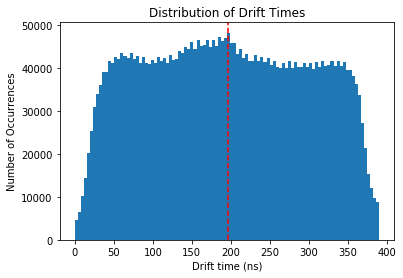

#### For the Scintillator Trigger

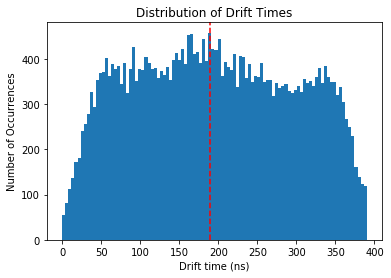

In [75]:
def make_hist(df):
    events = df.copy(deep=False)

    # !!! whole cell is a bit different

    #  Check if t0_123 & t0_234 are "reasonable close" to each other, if they are compute average
    mask = np.abs(events['t0_123'] - events['t0_234']) < T_M/4
    events.loc[mask, 't0'] = (events['t0_123'] + events['t0_234'])/2
    events.loc[~mask, 't0'] = np.nan

    #  Optionally drop t0_123 and t0_234
    events.drop(['t0_123', 't0_234'], inplace=True, axis=1)

    #  Compute drift time and position
    events['drift_time'] = events['time'] - events['t0']
    events['x'] = v_d*events['drift_time']

    #  Clean up data for events which have a negative drift time or a position over 21mm
    events.loc[(events['drift_time']<0) | (events['x']>L/2), 't0'] = np.nan

    hist, edges,_ = plt.hist(events.loc[events['t0'].notna(), 'drift_time'], bins=100)
    mid_edges = (edges[:-1] + edges[1:])/2

    plt.title('Distribution of Drift Times')
    plt.axvline(mid_edges[np.argmax(hist)], c='r', ls='--')
    plt.xlabel('Drift time (ns)')
    plt.ylabel('Number of Occurrences')

    plt.show()

    return events


printmd('#### For the Mean time Trigger')    
events_mtt = make_hist(events_mtt)
if not trigger_st.empty:
    printmd('#### For the Scintillator Trigger')    
    events_st = make_hist(events_st)

## <span style='color:  gray'> FILTERING THE DATA </span>

In [76]:
def print_useful_events(df):
    events = df.copy(deep=False)

    # Ratio of "useful rows" to all rows !!!
    try:
        print('"useful rows" / "all rows": ', 1 - len(events[events['t0'].isna()])/events.shape[0]) #!!!
    except ZeroDivisionError:
        print('Error: Dataframe is empty')

    #  Event is counted as useful if 4 or more times are available
    event_groups = events.loc[events['t0'].notna(),'time'].groupby('event').count() #!!!
    # print(event_groups) 
    try:
        print('"useful events" / "all events"', (event_groups>3).sum()/len(event_groups))  # some events only have 3 (or below) hits
    except ZeroDivisionError:
        print('Error: Dataframe is empty')

printmd('### Useful Events')
print('Mean Time Trigger:')
print_useful_events(events_mtt)
if not trigger_st.empty:
    print('\n','Scintillator Trigger')
    print_useful_events(events_st)

### Useful Events

Mean Time Trigger:
"useful rows" / "all rows":  0.7248652838992968
"useful events" / "all events" 0.9690319274265875

 Scintillator Trigger
"useful rows" / "all rows":  0.6337090354499126
"useful events" / "all events" 0.9809257375381485


### Now we filter the data according to the following criteria
1. Drop hits that do not align
2. Obtain events that have at least one hit per layer (i.e. 4 layer representation)
3. Sort out events that have only one detector representation

In [77]:
def prepare_for_vis(df):
    # Drop all not aligning hits
    visual_evs = df.dropna(subset = ['t0']).copy() #!!!

    # deleted something !!!
    
    #  Sort out events which do not go through each layer for each present detector #!!!
    go_through_each_lay = (visual_evs.loc[:,['layer','detector']].groupby(['event','detector']).nunique() == 4).loc[:,'layer']
    go_through_each_lay = go_through_each_lay.groupby('event').all()
    
    #  Sort out events which are only registered in one detector
    multiple_detectors = visual_evs.loc[:,'detector'].groupby('event').nunique() > 1
    
    #  Combine the two masks
    index_mask = go_through_each_lay & multiple_detectors

    #  Apply mask to the dataframe
    visual_evs = visual_evs.loc[visual_evs.index.get_level_values(0).map(index_mask),:]

    #  Reindex the event index level starting from 1
    visual_evs.reset_index(level='event', inplace=True)
    visual_evs.loc[:,'event'] = (visual_evs.loc[:,'event'].diff()!=0).cumsum()
    visual_evs.set_index(['event', visual_evs.index], inplace=True)
    
    return visual_evs

# !!! deleted comment
events_mtt_vis = prepare_for_vis(events_mtt)
printmd('### Event 1 for the Mean time Trigger')
display(events_mtt_vis.head(8))
if not trigger_st.empty:
    events_st_vis = prepare_for_vis(events_st)
    printmd('### Event 1 for the Scintillator Trigger')
    display(events_st_vis.head(8))

### Event 1 for the Mean time Trigger

FPGA  TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                          
1     415     1.0         16.0  1.897417e+09       452.0      17.0   
      411     1.0         14.0  1.897417e+09       450.0       9.0   
      417     1.0         15.0  1.897417e+09       458.0       9.0   
      409     1.0         13.0  1.897417e+09       445.0      24.0   
      414     1.0        104.0  1.897417e+09       459.0      24.0   
      410     1.0        102.0  1.897417e+09       447.0       8.0   
      412     1.0         99.0  1.897417e+09       455.0      27.0   
      416     1.0        101.0  1.897417e+09       452.0      16.0   

                     time  detector  layer  cell            t0  drift_time  \
event index                                                                  
1     415    11314.166667         3      1     4  11130.520833  183.645833   
      411    11257.500000         3      2     4  11130.520833  126.979167   
      417    11457.500000         3      3     4  11130.520833  326.979167   
      409    11145.000000         3      4     4  11130.520833   14.479167   
      414    11495.000000         4      1    10  11123.229167  371.770833   
      410    11181.666667         4      2    10  11123.229167   58.437500   
      412    11397.500000         4      3     9  11123.229167  274.270833   
      416    11313.333333         4      4    10  11123.229167  190.104167   

                     x  
event index             
1     415     9.888622  
      411     6.837340  
      417    17.606571  
      409     0.779647  
      414    20.018429  
      410     3.146635  
      412    14.768429  
      416    10.236378

### Event 1 for the Scintillator Trigger

FPGA  TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                           
1     246685   1.0         16.0  1.918507e+09      2112.0      26.0   
      246690   1.0         14.0  1.918507e+09      2118.0      20.0   
      246681   1.0         15.0  1.918507e+09      2109.0       1.0   
      246687   1.0         13.0  1.918507e+09      2121.0      22.0   
      246686   1.0         68.0  1.918507e+09      2112.0      10.0   
      246688   1.0         66.0  1.918507e+09      2109.0       6.0   
      246680   1.0         67.0  1.918507e+09      2108.0      13.0   
      246684   1.0         65.0  1.918507e+09      2112.0      18.0   

                      time  detector  layer  cell            t0  drift_time  \
event index                                                                   
1     246685  52821.666667         3      1     4  52672.812500  148.854167   
      246690  52966.666667         3      2     4  52672.812500  293.854167   
      246681  52725.833333         3      3     4  52672.812500   53.020833   
      246687  53043.333333         3      4     4  52672.812500  370.520833   
      246686  52808.333333         4      1     1  52548.229167  260.104167   
      246688  52730.000000         4      2     1  52548.229167  181.770833   
      246680  52710.833333         4      3     1  52548.229167  162.604167   
      246684  52815.000000         4      4     1  52548.229167  266.770833   

                      x  
event index              
1     246685   8.015224  
      246690  15.822917  
      246681   2.854968  
      246687  19.951122  
      246686  14.005609  
      246688   9.787660  
      246680   8.755609  
      246684  14.364583

***
# <a id =7></a><br> V. THE DETECTOR MATRIX 
 [Content Outline](#6)
 

The following paths represent some of the event trajectories found in the data. <span style='color:blue'> Blue </span> dots indicate paths at the right of the anodic wire, while <span style='color:green'> green </span> dots indicate paths at the left as in the project description

#### Event Path 1

This event follows a trajectory of a particle through detectors 3 and 4.

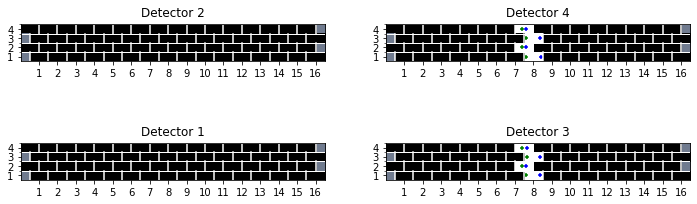

#### Event Path 2

This event follows a trajectory of a particle through detectors 1 and 2.

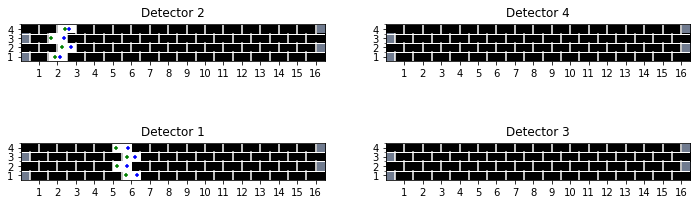

#### Event Path 3

This trajectory presents a particle that may !!!(I would add the 'may' because maybe its also just noise :D) has excited electrons in the cells, therefore a detection of multiple hits is present. Further filtration would be needed to avoid these kinds of path from showing up, nevertheless, we can use this to characterize the behavior of the particle as it traverses the detectors.

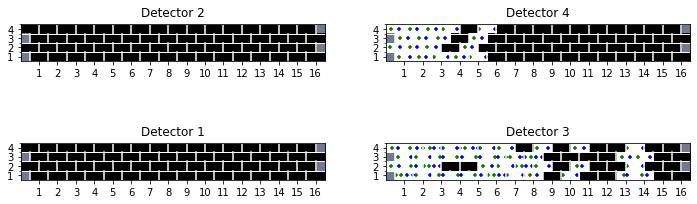

#### Event Path 4

Trajectory of event detected by scintillator trigger.

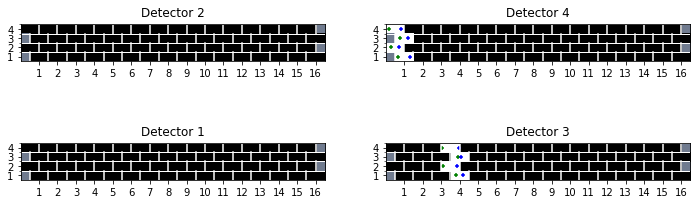

In [121]:
def plotDetector(ax, event, is_empty):
    detector = np.zeros((4,16*2+1))

    even_layers = event['layer']%2 == 0
    odd_layers = even_layers == False

    def fillDetectorMatrix(matrix, i, j, s=0):
        matrix[i,j*2+s] = 1
        matrix[i,j*2+1+s] = 1

    def plotLeftRight(ax, cell, position, layer, odd, left):
        if left == True:
            ax.scatter((cell-1-position/L)*2+0.5+odd, layer-1, s=10, c='g', marker='+')
        else:
            ax.scatter((cell-1+position/L)*2+0.5+odd, layer-1, s=10, c='b', marker='+')
    
    if is_empty == False:
        fillDetectorMatrix(detector, event.loc[even_layers,'layer']-1,
                    event.loc[even_layers,'cell']-1, s=0)
        fillDetectorMatrix(detector, event.loc[odd_layers,'layer']-1,
                    event.loc[odd_layers,'cell']-1, s=1)

        for odd,left in [[odd, left] for odd in [True, False] for left in [True,False]]:
            if odd == True:
                layers = odd_layers
            else:
                layers = even_layers

            plotLeftRight(ax, event.loc[layers, 'cell'], event.loc[layers, 'x'],
                     event.loc[layers, 'layer'], odd, left)

    detector[(0,1,2,3),(0,32,0,32)] = 0.5 # Mark "cell offset"
    ax.matshow(detector, origin='lower', cmap='bone', vmin=0, vmax=1)

    # Major ticks
    ax.set_xticks(np.arange(1.5, 32, 2));
    ax.set_yticks(np.arange(0, 4, 1));

    # # Labels for major ticks
    ax.set_xticklabels(np.arange(1, 17, 1));
    ax.set_yticklabels(np.arange(1, 5, 1));

    # # Minor ticks
    # # ax.set_xticks(np.arange(-.5, 32, 2), minor=True);
    ax.set_yticks(np.arange(0.5, 4, 1), minor=True);

    ax.grid(which='minor', axis='y', color='w', linewidth=1)
    ax.xaxis.set_ticks_position('bottom')
    
    vert_line = np.array([0,1])
    for l in range(4):
        for c in range(16):
            if l%2 == 0:
                ax.plot([c*2+0.5,c*2+0.5], vert_line+l-0.5, c='w')
            else:
                ax.plot([c*2+1.5,c*2+1.5], vert_line+l-0.5, c='w')

def plotEvent(event):
    fig, axes = plt.subplots(2, 2, figsize=(12,4))

    for i in range(0,4):
        sub_ev = event.loc[event['detector']==i+1, :]
        plotDetector(axes[1-i%2,i//2], sub_ev, sub_ev.empty)
        axes[1-i%2,i//2].set_title('Detector {}'.format(i+1))
    # TODO legend

    plt.show()


printmd("The following paths represent some of the event trajectories found in the data. <span style='color:blue'> Blue </span> dots indicate paths at the right of the anodic wire, while <span style='color:green'> green </span> dots indicate paths at the left as in the project description")
printmd("#### Event Path 1")
printmd("This event follows a trajectory of a particle through detectors 3 and 4.")
plotEvent(events_mtt_vis.loc[47])

printmd("#### Event Path 2")
printmd("This event follows a trajectory of a particle through detectors 1 and 2.")
plotEvent(events_mtt_vis.loc[5]) # !!! had to change this because old one didnt go through 1 and 2

printmd("#### Event Path 3")
printmd("This trajectory presents a particle that may !!!(I would add the 'may' because maybe its also just noise :D) has excited electrons in the cells, therefore a detection of multiple hits is present. Further filtration would be needed to avoid these kinds of path from showing up, nevertheless, we can use this to characterize the behavior of the particle as it traverses the detectors.")
plotEvent(events_mtt_vis.loc[57]) # !!! also had to change

if not trigger_st.empty: #!!! added one event for scintillator
    printmd("#### Event Path 4")
    printmd("Trajectory of event detected by scintillator trigger.")
    plotEvent(events_st_vis.loc[1])

#### Final Remarks: 
We have (!!! sounds strange to say 'the team' I think :D) fulfilled the project goals through the previous code. In the end, valid trajectories were found through the sorting and filtering of the data using the trigger channels, mean time and scintillator. 